# MoleculeDict Tutorial Examples

This notebook demonstrates the **MoleculeDict** class from iSLAT, which provides a powerful interface for managing collections of molecules:

## Key Features Demonstrated:
1. **Creating and Loading Molecules** - Initialize MoleculeDict and load multiple molecules
2. **Summed Flux Calculations** - Get combined spectra from all molecules
3. **Visibility Control** - Toggle individual and bulk molecule visibility
4. **Bulk Parameter Updates** - Efficiently update parameters across multiple molecules
5. **Global Parameters** - Shared parameters that apply to all molecules
6. **Cache Management** - Inspect and validate internal caching for performance
7. **Matched Spectral Sampling** - Interpolate models to match observational wavelength grids
8. **Dictionary Operations** - Standard Python dict functionality

In [1]:
# Now import the core iSLAT data types
import numpy as np
import matplotlib.pyplot as plt

# Import data types from iSLAT
from iSLAT.Modules.DataTypes import MoleculeDict

print("iSLAT data types imported successfully!")

iSLAT data types imported successfully!


In [2]:
from iSLAT.Modules.FileHandling import hitran_data_folder_path as data_dir

# Define paths to HITRAN parameter files for the molecules we want to create

water_par_file = data_dir / "data_Hitran_H2O.par"
co_par_file    = data_dir / "data_Hitran_CO.par"
co2_par_file   = data_dir / "data_Hitran_CO2.par"

## 1. Creating a MoleculeDict and Loading Molecules

The `MoleculeDict` class is a specialized dictionary for managing collections of molecules. It provides:
- Summed flux from multiple molecules
- Visibility control
- Global parameter management
- Efficient caching across all molecules

In [3]:
# Create a MoleculeDict with global parameters
wavelength_range = (5.0, 25.0)

mol_dict = MoleculeDict(
    global_distance=160,
    global_stellar_rv=0.0,
    global_wavelength_range=wavelength_range,
    global_model_pixel_res=0.001
)

# Create multiple molecules
molecules_to_create = {
    "H2O": {"Molecule Name": "H2O", "temp": 850, "n_mol": 1e18, "color": "blue", "displaylabel": "H2O", "File Path": water_par_file},
    "CO": {"Molecule Name": "CO", "temp": 1000, "n_mol": 5e17, "color": "red", "displaylabel": "CO", "File Path": co_par_file},
    "CO2": {"Molecule Name": "CO2", "temp": 500, "n_mol": 2e17, "color": "green", "displaylabel": "CO2", "File Path": co2_par_file},
}

mol_dict.load_molecules(molecules_data=[mol for mol in molecules_to_create.values() if mol.get("Molecule Name")],
                        initial_molecule_parameters=molecules_to_create)

print(f"\nMoleculeDict contains {len(mol_dict)} molecules: {list(mol_dict.keys())}")

Deferring intensity calculations for 3 molecules

MoleculeDict contains 3 molecules: ['H2O', 'CO', 'CO2']


In [4]:
# Get summed flux from all visible molecules
# Create a wavelength grid for the summed flux
wave_grid = np.linspace(5.0, 25.0, 20001)

summed_wave, summed_flux = mol_dict.get_summed_flux(wave_grid, visible_only=True)

print(f"Summed spectrum: {len(summed_wave)} points")
print(f"Peak flux: {np.max(summed_flux):.4f} Jy")

Calculating intensity for CO2: T=500.0K, N_mol=2.00e+17, dv=1.0
Calculating intensity for CO: T=1000.0K, N_mol=5.00e+17, dv=1.0
Calculating intensity for H2O: T=850.0K, N_mol=1.00e+18, dv=1.0
Summed spectrum: 20001 points
Peak flux: 0.5102 Jy


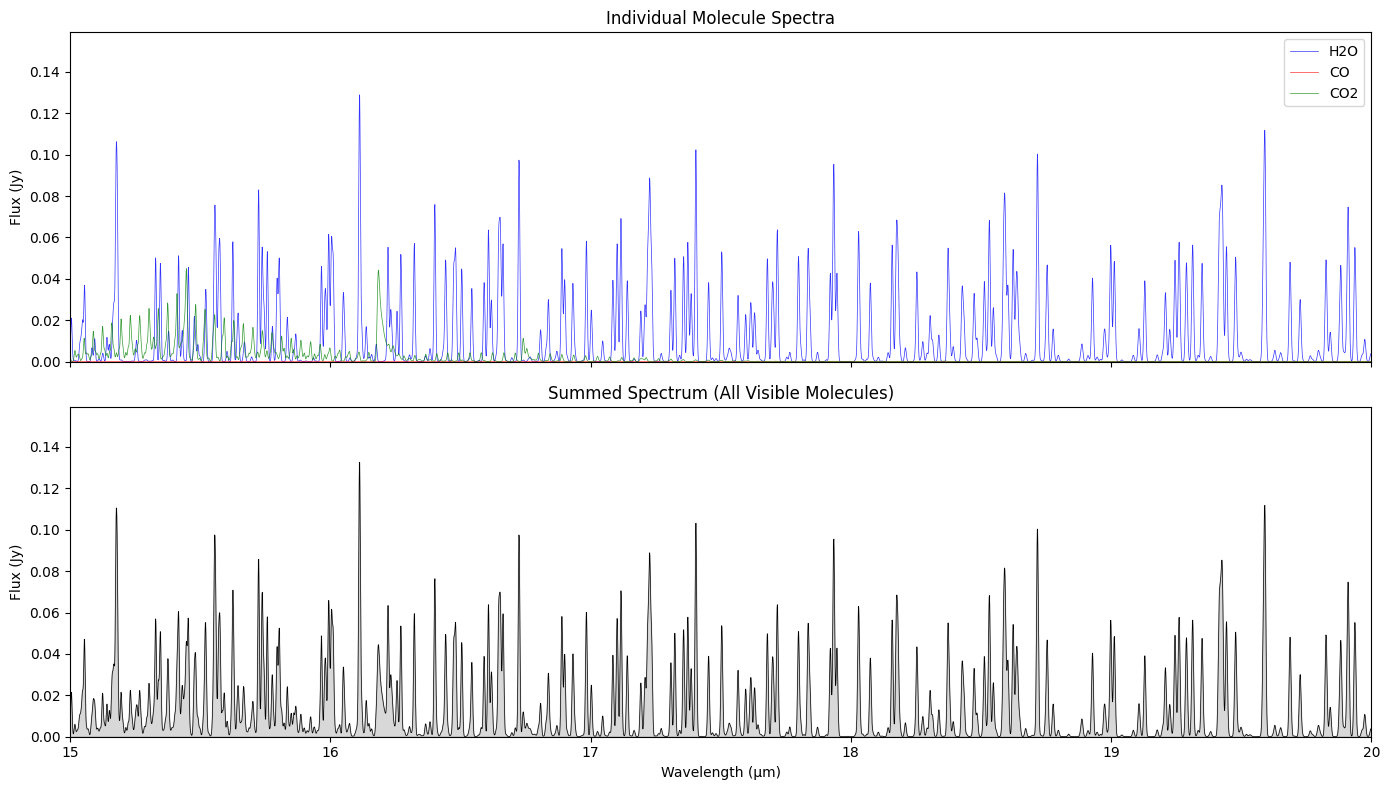

In [5]:
# Plot individual molecules and summed spectrum
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top panel: individual molecules
ax1 = axes[0]
for mol_name, mol in mol_dict.items():
    wave, flux = mol.get_flux(return_wavelengths=True)
    ax1.plot(wave, flux, color=mol.color, linewidth=0.5, label=mol.displaylabel, alpha=0.8)

ax1.set_ylabel('Flux (Jy)')
ax1.set_title('Individual Molecule Spectra')
ax1.legend(loc='upper right')
ax1.set_xlim(15, 20)
mask = (summed_wave >= 15) & (summed_wave <= 20)
ax1.set_ylim(0, np.max(summed_flux[mask])*1.2)

# Bottom panel: summed spectrum
ax2 = axes[1]
ax2.fill_between(summed_wave, 0, summed_flux, alpha=0.3, color='gray', label='Summed flux')
ax2.plot(summed_wave, summed_flux, 'k-', linewidth=0.5)
ax2.set_xlabel('Wavelength (μm)')
ax2.set_ylabel('Flux (Jy)')
ax2.set_title('Summed Spectrum (All Visible Molecules)')
ax2.set_xlim(15, 20)
mask = (summed_wave >= 15) & (summed_wave <= 20)
ax2.set_ylim(0, np.max(summed_flux[mask]) * 1.2)

plt.tight_layout()
plt.show()

Visible molecules: {'CO', 'H2O'}


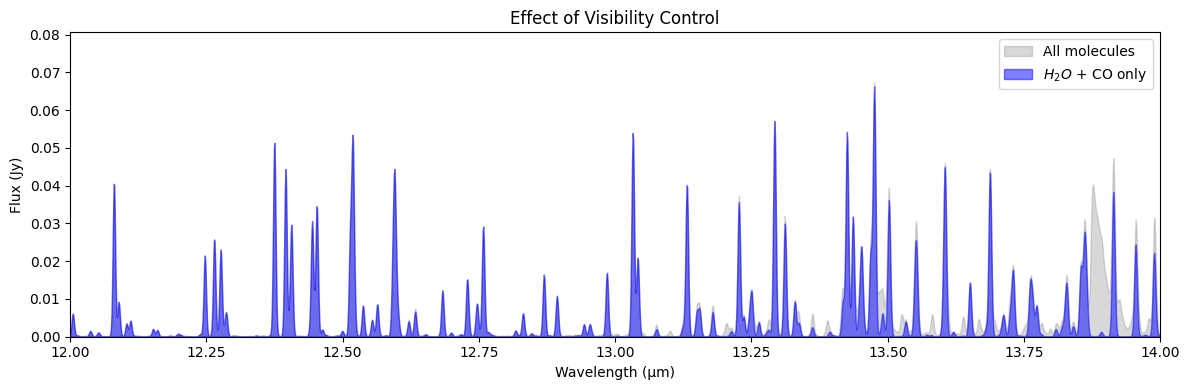

In [6]:
# Visibility control - hide CO2 and recalculate
mol_dict["CO2"].is_visible = False

visible_mols = mol_dict.get_visible_molecules()
print(f"Visible molecules: {visible_mols}")

# Get summed flux with only visible molecules
summed_wave2, summed_flux2 = mol_dict.get_summed_flux(wave_grid, visible_only=True)

# Compare
fig, ax = plt.subplots(figsize=(12, 4))
ax.fill_between(summed_wave, 0, summed_flux, alpha=0.3, color='gray', label='All molecules')
ax.fill_between(summed_wave2, 0, summed_flux2, alpha=0.5, color='blue', label='$H_2O$ + CO only')
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Flux (Jy)')
ax.set_title('Effect of Visibility Control')
ax.legend()
ax.set_xlim(12, 14)
mask = (summed_wave >= 12) & (summed_wave <= 14)
ax.set_ylim(0, np.max(summed_flux[mask]) * 1.2)

plt.tight_layout()
plt.show()

## 2. Summed Flux and Visibility Control

You can get the combined spectrum from multiple molecules and control which molecules contribute using visibility flags.

Currently visible: {'CO', 'H2O'}
Total molecules: ['H2O', 'CO', 'CO2']


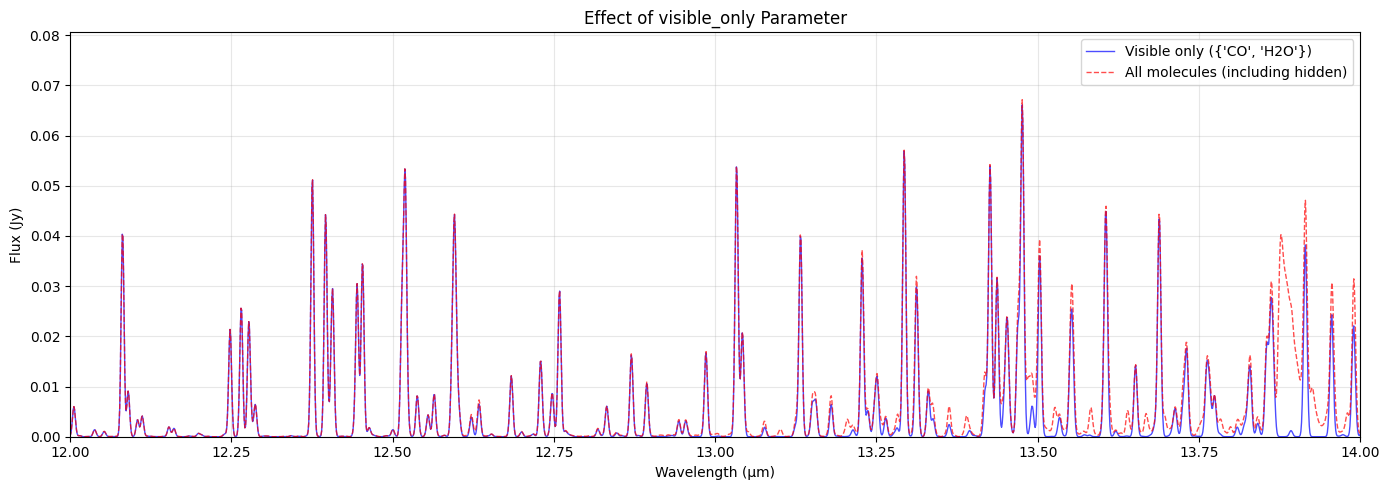

In [7]:
# Compare summed flux with visible_only=True vs False
wave_grid = np.linspace(5.0, 25.0, 20001)

# Set CO2 as invisible
mol_dict["CO2"].is_visible = False

# Get summed flux with only visible molecules
wave_visible, flux_visible = mol_dict.get_summed_flux(wave_grid, visible_only=True)

# Get summed flux including invisible molecules
wave_all, flux_all = mol_dict.get_summed_flux(wave_grid, visible_only=False)

# Check which molecules are visible
visible_names = mol_dict.get_visible_molecules()
print(f"Currently visible: {visible_names}")
print(f"Total molecules: {list(mol_dict.keys())}")

# Plot comparison
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(wave_visible, flux_visible, 'b-', linewidth=1, label=f'Visible only ({visible_names})', alpha=0.7)
ax.plot(wave_all, flux_all, 'r--', linewidth=1, label='All molecules (including hidden)', alpha=0.7)
ax.set_xlabel('Wavelength (μm)')
ax.set_ylabel('Flux (Jy)')
ax.set_title('Effect of visible_only Parameter')
ax.legend()
ax.set_xlim(12, 14)
mask = (wave_all >= 12) & (wave_all <= 14)
ax.set_ylim(0, np.max(flux_all[mask]) * 1.2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Reset all to visible
mol_dict.bulk_set_visibility(is_visible=True)

## 3. Bulk Visibility Control

Instead of setting visibility on individual molecules, you can use `bulk_set_visibility()` to efficiently update multiple molecules at once. This is faster because it only invalidates the cache once.

In [8]:
# Turn all molecules off at once
mol_dict.bulk_set_visibility(is_visible=False)
print(f"After bulk hide - Visible molecules: {mol_dict.get_visible_molecules()}")

# Turn only specific molecules on
mol_dict.bulk_set_visibility(is_visible=True, molecule_names=["H2O", "CO"])
print(f"After selective show - Visible molecules: {mol_dict.get_visible_molecules()}")

# Turn all molecules back on
mol_dict.bulk_set_visibility(is_visible=True)
print(f"After bulk show all - Visible molecules: {mol_dict.get_visible_molecules()}")

After bulk hide - Visible molecules: set()
After selective show - Visible molecules: {'CO', 'H2O'}
After bulk show all - Visible molecules: {'CO2', 'CO', 'H2O'}


## 4. Bulk Parameter Updates

The `bulk_update_parameters()` method allows you to change the same parameter across multiple molecules at once. This is useful for exploring parameter space or applying systematic changes.

In [9]:
# Store original parameters for comparison
original_temps = {name: mol.temp for name, mol in mol_dict.items()}
print("Original temperatures:")
for name, temp in original_temps.items():
    print(f"  {name}: {temp} K")

# Update radius for all molecules at once
mol_dict.bulk_update_parameters({'radius': 1.0})  # Set all radii to 1.0 AU
print("\nAfter bulk radius update:")
for name, mol in mol_dict.items():
    print(f"  {name}: radius = {mol.radius} AU")

# Update multiple parameters for specific molecules only
mol_dict.bulk_update_parameters(
    {'temp': 700, 'n_mol': 3e17}, 
    molecules=["H2O", "CO2"]
)
print("\nAfter selective temp/n_mol update:")
for name, mol in mol_dict.items():
    print(f"  {name}: T = {mol.temp} K, N = {mol.n_mol:.1e} cm^-2")

Original temperatures:
  H2O: 850.0 K
  CO: 1000.0 K
  CO2: 500.0 K

After bulk radius update:
  H2O: radius = 1.0 AU
  CO: radius = 1.0 AU
  CO2: radius = 1.0 AU

After selective temp/n_mol update:
  H2O: T = 700.0 K, N = 3.0e+17 cm^-2
  CO: T = 1000.0 K, N = 5.0e+17 cm^-2
  CO2: T = 700.0 K, N = 3.0e+17 cm^-2


### Selecting Molecules for Bulk Updates

The `molecules` parameter of `bulk_update_parameters()` accepts an optional sequence of identifiers. You can specify molecules by:

| Identifier type | Example |
|-----------------|---------|
| **Name** (str) | `"H2O"`, `"CO"` |
| **Index** (int) | `0`, `2` (position in the dict) |
| **Object** (Molecule) | `mol_dict["H2O"]` |
| **Mixed** | `["H2O", 1, mol_dict["CO2"]]` |
| **None** (default) | Applies to **all** molecules |

In [10]:
# --- Different ways to specify which molecules to update ---

# 1. By name (str)
mol_dict.bulk_update_parameters({'temp': 900}, molecules=["H2O", "CO"])
print("By name — H2O temp:", mol_dict["H2O"].temp, "| CO temp:", mol_dict["CO"].temp)

# 2. By index (int) — position in the dict
mol_dict.bulk_update_parameters({'temp': 600}, molecules=[2])   # third molecule (CO2)
print("By index — CO2 temp:", mol_dict["CO2"].temp)

# 3. By Molecule object
mol_dict.bulk_update_parameters({'temp': 750}, molecules=[mol_dict["CO"]])
print("By object — CO temp:", mol_dict["CO"].temp)

# 4. Mixed identifiers in one call
mol_dict.bulk_update_parameters(
    {'radius': 0.8},
    molecules=["H2O", 2, mol_dict["CO"]],   # str + int + Molecule
)
print("Mixed — radii:", {n: m.radius for n, m in mol_dict.items()})

# 5. None (default) — updates ALL molecules
mol_dict.bulk_update_parameters({'broad': 1.0})
print("All molecules — broad:", {n: m.broad for n, m in mol_dict.items()})

By name — H2O temp: 900.0 | CO temp: 900.0
By index — CO2 temp: 600.0
By object — CO temp: 900.0
Mixed — radii: {'H2O': 0.8, 'CO': 1.0, 'CO2': 0.8}
All molecules — broad: {'H2O': 1.0, 'CO': 1.0, 'CO2': 1.0}


## 5. Global Parameters

MoleculeDict maintains global parameters that can be applied to all molecules. Changing these automatically updates all molecules in the collection.

In [11]:
# View current global parameters
print("Current global parameters:")
print(f"  Distance: {mol_dict.global_distance} pc")
print(f"  Wavelength range: {mol_dict.global_wavelength_range} μm")
print(f"  Stellar RV: {mol_dict.global_stellar_rv} km/s")
print(f"  Model pixel resolution: {mol_dict.global_model_pixel_res} μm")
print(f"  Intensity calculation method: {mol_dict.global_intensity_calculation_method}")

# Change the global distance - this updates ALL molecules
print("\n--- Changing global distance to 140 pc ---")
mol_dict.global_distance = 140

# Verify all molecules were updated
print("Molecule distances after global update:")
for name, mol in mol_dict.items():
    print(f"  {name}: {mol.distance} pc")

# Reset to original distance
mol_dict.global_distance = 160

Current global parameters:
  Distance: 160.0 pc
  Wavelength range: (5.0, 25.0) μm
  Stellar RV: 0.0 km/s
  Model pixel resolution: 0.001 μm
  Intensity calculation method: curve_growth

--- Changing global distance to 140 pc ---
Molecule distances after global update:
  H2O: 140.0 pc
  CO: 140.0 pc
  CO2: 140.0 pc


## 6. Cache Management

MoleculeDict uses intelligent caching to avoid redundant calculations. You can inspect and validate the cache state.

In [12]:
# First, trigger a calculation to populate the cache
wave_grid = np.linspace(5.0, 25.0, 20001)
_ = mol_dict.get_summed_flux(wave_grid, visible_only=True)

# Get cache statistics
cache_stats = mol_dict.get_cache_stats()
print("Cache Statistics:")
print(f"  Number of cached entries: {cache_stats['summed_flux_cache_size']}")

for entry in cache_stats['summed_flux_cache_entries']:
    print(f"\n  Entry details:")
    print(f"    Wavelength points: {entry['wavelength_points']}")
    print(f"    Flux points: {entry['flux_points']}")
    print(f"    Memory size: {entry['memory_size_mb']:.2f} MB")

# Validate cache integrity
validation = mol_dict.validate_cache_integrity()
print(f"\nCache Validation:")
print(f"  Valid entries: {validation['valid_entries']}")
print(f"  Invalid entries: {validation['invalid_entries']}")

Calculating intensity for CO2: T=600.0K, N_mol=3.00e+17, dv=1.0
Calculating intensity for CO: T=900.0K, N_mol=5.00e+17, dv=1.0
Calculating intensity for H2O: T=900.0K, N_mol=3.00e+17, dv=1.0
Cache Statistics:
  Number of cached entries: 1

  Entry details:
    Wavelength points: 20001
    Flux points: 20001
    Memory size: 0.31 MB

Cache Validation:
  Valid entries: 1
  Invalid entries: 0


## 7. Matched Spectral Sampling

When comparing models to observational data, you can enable `match_spectral_sampling` to interpolate model flux onto the exact data wavelength grid pixel-by-pixel.

In [13]:
# Create an irregular wavelength grid (like real observational data)
# This simulates JWST MIRI-MRS wavelength sampling
irregular_wave = np.concatenate([
    np.linspace(10.0, 12.0, 100),   # Channel 1
    np.linspace(12.5, 15.0, 150),   # Channel 2 (different sampling)
    np.linspace(15.5, 18.0, 120),   # Channel 3
])

print(f"Irregular wavelength grid: {len(irregular_wave)} points")
print(f"Range: {irregular_wave.min():.2f} - {irregular_wave.max():.2f} μm")

# Without matched sampling - returns model's native grid
mol_dict.match_spectral_sampling = False
wave_native, flux_native = mol_dict.get_summed_flux(irregular_wave, visible_only=True)
print(f"\nWithout matched sampling: {len(wave_native)} points (native model grid)")

# With matched sampling - interpolates to match input wavelengths exactly
mol_dict.match_spectral_sampling = True
wave_matched, flux_matched = mol_dict.get_summed_flux(irregular_wave, visible_only=True)
print(f"With matched sampling: {len(wave_matched)} points (matches input exactly)")

# Reset
mol_dict.match_spectral_sampling = False

Irregular wavelength grid: 370 points
Range: 10.00 - 18.00 μm

Without matched sampling: 20001 points (native model grid)
With matched sampling: 370 points (matches input exactly)


## 8. Iterating Over Molecules

MoleculeDict behaves like a standard Python dictionary, so you can use familiar iteration patterns.

In [14]:
# Standard dictionary operations work as expected
print(f"Number of molecules: {len(mol_dict)}")
print(f"Molecule names: {list(mol_dict.keys())}")
print(f"Is H2O in dict? {'H2O' in mol_dict}")

# Iterate over all molecules and print a summary
print("\nMolecule Summary:")
print("-" * 60)
for mol_name, molecule in mol_dict.items():
    wave, flux = molecule.get_flux(return_wavelengths=True)
    peak_flux = np.max(flux)
    print(f"{mol_name:8s} | T={molecule.temp:4.0f}K | N={molecule.n_mol:.1e} | "
          f"R={molecule.radius:.1f}AU | Peak={peak_flux:.2e} Jy")

# Get visible molecules as Molecule objects (not just names)
visible_objects = mol_dict.get_visible_molecules(return_objects=True)
print(f"\nVisible molecule objects: {[m.name for m in visible_objects]}")

Number of molecules: 3
Molecule names: ['H2O', 'CO', 'CO2']
Is H2O in dict? True

Molecule Summary:
------------------------------------------------------------
H2O      | T= 900K | N=3.0e+17 | R=0.8AU | Peak=7.20e-01 Jy
CO       | T= 900K | N=5.0e+17 | R=1.0AU | Peak=3.39e-01 Jy
CO2      | T= 600K | N=3.0e+17 | R=0.8AU | Peak=1.00e+00 Jy

Visible molecule objects: ['CO2', 'CO', 'H2O']


## 9. Summary

### MoleculeDict Key Features

| Feature | Method/Property | Description |
|---------|-----------------|-------------|
| Load molecules | `load_molecules()` | Initialize multiple molecules from data dictionary |
| Summed flux | `get_summed_flux()` | Get combined spectrum from visible molecules |
| Visibility | `get_visible_molecules()` | Get list of visible molecule names or objects |
| Bulk visibility | `bulk_set_visibility()` | Efficiently toggle visibility for multiple molecules |
| Bulk parameters | `bulk_update_parameters()` | Update parameters across multiple molecules |
| Global parameters | `global_distance`, `global_wavelength_range`, etc. | Shared parameters applied to all molecules |
| Spectral matching | `match_spectral_sampling` | Interpolate model to match data wavelengths |
| Caching | `get_cache_stats()`, `validate_cache_integrity()` | Inspect and validate internal caches |
| Iteration | Standard dict methods | `keys()`, `values()`, `items()`, `in`, `len()` |